In [49]:
import pandas as pd
import numpy as np

In [85]:
adj_prediction=pd.read_pickle('adjusted_prediction.pkl')

close_price=pd.read_csv('数据/dfcf-收盘价.csv',encoding='gb18030',dtype={'SECURITYCODE':str})
market_captical=pd.read_csv('数据/dfcf-总市值.csv',encoding='gb18030',dtype={'SECURITYCODE':str})

In [61]:
a_stock_conditions = close_price.SECURITYCODE.str.startswith('0') | \
                    close_price.SECURITYCODE.str.startswith('3') |  \
                    close_price.SECURITYCODE.str.startswith('6')
close_price = close_price[a_stock_conditions]
close_price = close_price.pivot(columns='SECURITYCODE', index='TRADEDATE', values='CLOSE_PRICE')
close_price.index = pd.to_datetime(close_price.index)

In [62]:
def change_date(x):
    return x.replace(day=1)
close_price.index = close_price.index.map(change_date)

In [66]:
ret = close_price.pct_change(fill_method=None)

In [5]:
#market_captical=pd.read_csv('/Users/chenxj00/Documents/长江证券/一直预期gitlab/数据/dfcf-总市值.csv',encoding='gb18030',dtype={'SECURITYCODE':str})
market_captical['TRADEDATE']=pd.to_datetime(market_captical['TRADEDATE'])
market_captical['without_year_date']=market_captical['TRADEDATE'].map(lambda x: change_date(x))
market_captical['date']=pd.to_datetime(market_captical['TRADEDATE'].map(lambda x: str(x.year))+'-'+market_captical['without_year_date'])
market_captical=market_captical[['ZSZ','SECURITYCODE','date']]
market_captical_after2015=market_captical[market_captical['date'].map(lambda x: x.year>2014)].pivot(index='date',columns='SECURITYCODE',values='ZSZ')

In [110]:
adj_prediction['000001']

2015-01-01            NaN
2015-05-01    2.29848e+10
2015-09-01    2.31497e+10
2015-11-01      2.302e+10
2016-01-01    2.54653e+06
2016-05-01    2.35688e+10
2016-09-01    2.34545e+10
2016-11-01    2.34769e+10
2017-01-01    2.49323e+06
2017-05-01     2.3918e+10
2017-09-01    2.32529e+10
2017-11-01    2.32732e+10
2018-01-01    2.47939e+06
2018-05-01    2.35526e+10
2018-09-01     2.3574e+10
2018-11-01    2.46852e+10
2019-01-01    2.69677e+06
2019-05-01    2.66816e+10
2019-09-01    2.72702e+10
2019-11-01    2.85553e+10
Name: 000001, dtype: object

In [102]:
PE_ratio = market_captical_after2015.divide(adj_prediction)

ZeroDivisionError: float division by zero

In [6]:
PE_ratio.to_pickle('PE_ratio.pkl')
market_captical_after2015.to_pickle('PCT_Change.pkl')

In [8]:
score_pivot = pd.read_pickle('PE_ratio.pkl')
ret = pd.read_pickle('PCT_Change.pkl')

In [89]:
score_pivot = PE_ratio.dropna(how='all').dropna(how='all', axis=1)

In [90]:
score_pivot = score_pivot.replace(np.inf, np.nan)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 39064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 30340 missing from cur

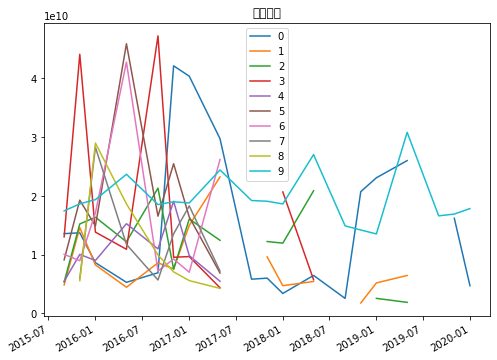

In [18]:
# 需要准备的两个数据
# score_pivot：处理好的因子值，数据类型为dataframe,index为日期，columns为股票代码，values为要测单调性的值
# ret：处理好的区间收益，数据类型为dataframe,index为日期（需要和score_pivot的index匹配），columns为股票代码，values为股票区间收益

df_quantile = pd.DataFrame()
n_groups = 10  # 回测单调性分成多少组

for i in range(n_groups):
    quantile_min=pd.Series()
    temp_min=list()
    for k in range(len(score_pivot.index.tolist())):
        index=score_pivot.index.tolist()[k]
        try:
            temp_value_min=np.percentile(np.array([j for j in score_pivot.loc[index].tolist() if not np.isnan(j)]),q=i*0.1)
            temp_min+=[temp_value_min]
        except:
            temp_min+=[np.nan]
    quantile_min = pd.Series(temp_min)
    quantile_min.index=score_pivot.index.tolist()  # 每组最小值
    quantile_pivot = pd.DataFrame(index=score_pivot.index, columns=score_pivot.columns)
    if i < 9:
        temp_max=list()
        for k in range(len(score_pivot.index.tolist())):
            index=score_pivot.index.tolist()[k]
            try:
                temp_value_max=np.percentile(np.array([j for j in score_pivot.loc[index].tolist() if not np.isnan(j)]),q=(i+1)*0.1)
                temp_max+=[temp_value_max]
            except:
                temp_max+=[np.nan]
        quantile_max = pd.Series(temp_max)
        quantile_max.index=score_pivot.index.tolist()  # 每组最小值
        quantile_pivot[(score_pivot.subtract(quantile_min, axis=0)>=0) & (score_pivot.subtract(quantile_max, axis=0)<0)] = 1.0  # 每组过滤只保留在最小值和最大值之间的数值
    else:
        quantile_pivot[score_pivot.subtract(quantile_min, axis=0)>=0] = 1.0 # 最大一组过滤只需要大于最小值
    df_weight = quantile_pivot.shift(1)  # 因子值要后移一单位时间：因为本时间节点的因子值对应下一个节点的收益率，否则会有未来函数
    df_quantile[i] = (df_weight*ret).mean(axis=1)  # 本组收益 = 权重 * 个股单位时间收益率
# 如果需要沪深300收益, ret_hs300为series,index为日期，values为区间收益
# df_quantile['沪深300'] = ret_hs300
(1+df_quantile).plot(figsize=(8,6), title='你的标题')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 39064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 30340 missing from cur

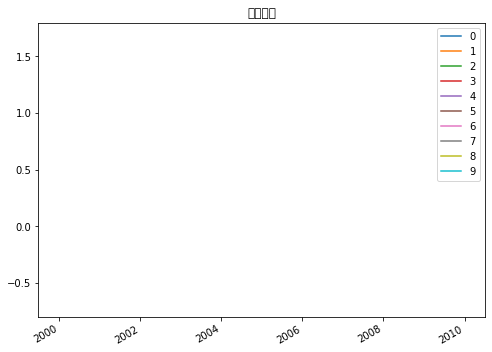

In [22]:
# 需要准备的两个数据
# score_pivot：处理好的因子值，数据类型为dataframe,index为日期，columns为股票代码，values为要测单调性的值
# ret：处理好的区间收益，数据类型为dataframe,index为日期（需要和score_pivot的index匹配），columns为股票代码，values为股票区间收益

df_quantile = pd.DataFrame()
n_groups = 10  # 回测单调性分成多少组

for i in range(n_groups):
    quantile_min = score_pivot.quantile(i*0.1, axis=1)  # 每组最小值
    quantile_pivot = pd.DataFrame(index=score_pivot.index, columns=score_pivot.columns)
    if i < 9:
        quantile_max = score_pivot.quantile((i+1)*0.1, axis=1) # 每组最大值，最大的一组不需要过滤
        quantile_pivot[(score_pivot.subtract(quantile_min, axis=0)>=0) & (score_pivot.subtract(quantile_max, axis=0)<0)] = 1.0  # 每组过滤只保留在最小值和最大值之间的数值
    else:
        quantile_pivot[score_pivot.subtract(quantile_min, axis=0)>=0] = 1.0 # 最大一组过滤只需要大于最小值
    df_weight = quantile_pivot.shift(1)  # 因子值要后移一单位时间：因为本时间节点的因子值对应下一个节点的收益率，否则会有未来函数
    df_quantile[i] = (df_weight*ret).mean(axis=1)  # 本组收益 = 权重 * 个股单位时间收益率
# 如果需要沪深300收益, ret_hs300为series,index为日期，values为区间收益
# df_quantile['沪深300'] = ret_hs300
(1+df_quantile).plot(figsize=(8,6), title='你的标题')

In [21]:
score_pivot = score_pivot.dropna(how='all', axis=1)